# 数据导入及解压

In [ ]:
!pip install py7zr

In [2]:
import os
import py7zr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageEnhance
import cv2


# 将要解压的压缩文件路径
archive = py7zr.SevenZipFile(r'/content/Rice Leaf Disease Images.7z', mode='r')
# 压缩文件的解压目录
archive.extractall(path=r'/content/src')
archive.close()

# 代码片段用于清空无关文件夹内数据，可折叠

In [10]:
import os
import shutil

def delete_all_files_in_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

# Usage
folder_path = '/content/src/Rice Leaf Disease Images/Bacterialblight_enhance'  # Replace with your folder path
delete_all_files_in_folder(folder_path)

# 预处理，图像增强部分

In [ ]:
'''
共采用了四种数据增强
imageDir 为原数据集的存放位置
saveDir  为数据增强后数据的存放位置
'''

def flip(root_path,img_name):   #翻转图像
    img = Image.open(os.path.join(root_path, img_name))
    filp_img = img.transpose(Image.FLIP_LEFT_RIGHT)
    # filp_img.save(os.path.join(root_path,img_name.split('.')[0] + '_flip.jpg'))
    return filp_img

def rotation(root_path, img_name):
    img = Image.open(os.path.join(root_path, img_name))
    rotation_img = img.rotate(20) #旋转角度
    # rotation_img.save(os.path.join(root_path,img_name.split('.')[0] + '_rotation.jpg'))
    return rotation_img

def randomColor(root_path, img_name): #随机颜色
    """
    对图像进行颜色抖动
    :param image: PIL的图像image
    :return: 有颜色色差的图像image
    """
    image = Image.open(os.path.join(root_path, img_name))
    random_factor = np.random.randint(0, 31) / 10.  # 随机因子
    color_image = ImageEnhance.Color(image).enhance(random_factor)  # 调整图像的饱和度
    random_factor = np.random.randint(10, 21) / 10.  # 随机因子
    brightness_image = ImageEnhance.Brightness(color_image).enhance(random_factor)  # 调整图像的亮度
    random_factor = np.random.randint(10, 21) / 10.  # 随机因子
    contrast_image = ImageEnhance.Contrast(brightness_image).enhance(random_factor)  # 调整图像对比度
    random_factor = np.random.randint(0, 31) / 10.  # 随机因子
    return ImageEnhance.Sharpness(contrast_image).enhance(random_factor)  # 调整图像锐度


def contrastEnhancement(root_path, img_name):  # 对比度增强
    image = Image.open(os.path.join(root_path, img_name))
    enh_con = ImageEnhance.Contrast(image)
    contrast = 1.5
    image_contrasted = enh_con.enhance(contrast)
    return image_contrasted

def brightnessEnhancement(root_path,img_name): # 亮度增强
    image = Image.open(os.path.join(root_path, img_name))
    enh_bri = ImageEnhance.Brightness(image)
    brightness = 1.5
    image_brightened = enh_bri.enhance(brightness)
    return image_brightened

def colorEnhancement(root_path,img_name): # 颜色增强
    image = Image.open(os.path.join(root_path, img_name))
    enh_col = ImageEnhance.Color(image)
    color = 1.5
    image_colored = enh_col.enhance(color)
    return image_colored

from PIL import Image
import os
import cv2
import numpy as np
imageDir="/content/dateset/Rice Leaf Disease Images/Bacterialblight/"     # 要改变的图片的路径文件夹
saveDir="/content/dateset/Rice Leaf Disease Images/Bacterialblight_enhance/"   # 要保存的图片的路径文件夹

for name in os.listdir(imageDir):
  # print(name)

  saveName= name[:-4]+"id.png"
  image = Image.open(os.path.join(imageDir, name))
  image.save(os.path.join(saveDir,saveName))

  saveName= name[:-4]+"be.png"
  saveImage=brightnessEnhancement(imageDir,name).convert('RGBA')
  saveImage.save(os.path.join(saveDir,saveName))

  saveName= name[:-4]+"fl.png"
  saveImage=flip(imageDir,name).convert('RGBA')
  saveImage.save(os.path.join(saveDir,saveName))

  saveName= name[:-4]+"ro.png"
  saveImage=rotation(imageDir,name).convert('RGBA')
  saveImage.save(os.path.join(saveDir,saveName))



# 划分训练集、验证集、测试集

In [3]:
import os
import random
import shutil
from shutil import copy2

def data_set_split(src_data_folder, target_data_folder, train_scale=0.6, val_scale=0.2, test_scale=0.2):
    '''
    读取源数据文件夹，生成划分好的文件夹，分为trian、val、test三个文件夹进行
    :param src_data_folder: 源文件夹
    :param target_data_folder: 目标文件夹
    :param train_scale: 训练集比例
    :param val_scale: 验证集比例
    :param test_scale: 测试集比例
    :return:
    '''
    print("开始数据集划分")
    class_names = os.listdir(src_data_folder)
    # 在目标目录下创建文件夹
    split_names = ['train', 'val', 'test']
    for split_name in split_names:
        split_path = os.path.join(target_data_folder, split_name)
        if os.path.isdir(split_path):
            pass
        else:
            os.mkdir(split_path)
        # 然后在split_path的目录下创建类别文件夹
        for class_name in class_names:
            class_split_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_split_path):
                pass
            else:
                os.mkdir(class_split_path)

    # 按照比例划分数据集，并进行数据图片的复制
    # 首先进行分类遍历
    for class_name in class_names:
        current_class_data_path = os.path.join(src_data_folder, class_name)
        current_all_data = os.listdir(current_class_data_path)
        current_data_length = len(current_all_data)
        current_data_index_list = list(range(current_data_length))
        random.shuffle(current_data_index_list)

        train_folder = os.path.join(os.path.join(target_data_folder, 'train'), class_name)
        val_folder = os.path.join(os.path.join(target_data_folder, 'val'), class_name)
        test_folder = os.path.join(os.path.join(target_data_folder, 'test'), class_name)
        train_stop_flag = current_data_length * train_scale
        val_stop_flag = current_data_length * (train_scale + val_scale)
        current_idx = 0
        train_num = 0
        val_num = 0
        test_num = 0
        for i in current_data_index_list:
            src_img_path = os.path.join(current_class_data_path, current_all_data[i])
            if current_idx <= train_stop_flag:
                copy2(src_img_path, train_folder)
                # print("{}复制到了{}".format(src_img_path, train_folder))
                train_num = train_num + 1
            elif (current_idx > train_stop_flag) and (current_idx <= val_stop_flag):
                copy2(src_img_path, val_folder)
                # print("{}复制到了{}".format(src_img_path, val_folder))
                val_num = val_num + 1
            else:
                copy2(src_img_path, test_folder)
                # print("{}复制到了{}".format(src_img_path, test_folder))
                test_num = test_num + 1

            current_idx = current_idx + 1

        print("*********************************{}*************************************".format(class_name))
        print(
            "{}类按照{}：{}：{}的比例划分完成，一共{}张图片".format(class_name, train_scale, val_scale, test_scale, current_data_length))
        print("训练集{}：{}张".format(train_folder, train_num))
        print("验证集{}：{}张".format(val_folder, val_num))
        print("测试集{}：{}张".format(test_folder, test_num))


src_data_folder = "/content/src/Rice Leaf Disease Images"  #划分前的数据集的位置
target_data_folder = "/content/dataset"  #划分后的数据集的位置
data_set_split(src_data_folder, target_data_folder)

开始数据集划分
*********************************Blast*************************************
Blast类按照0.6：0.2：0.2的比例划分完成，一共1440张图片
训练集/content/dataset/train/Blast：865张
验证集/content/dataset/val/Blast：288张
测试集/content/dataset/test/Blast：287张
*********************************Bacterialblight*************************************
Bacterialblight类按照0.6：0.2：0.2的比例划分完成，一共1584张图片
训练集/content/dataset/train/Bacterialblight：951张
验证集/content/dataset/val/Bacterialblight：317张
测试集/content/dataset/test/Bacterialblight：316张
*********************************Brownspot*************************************
Brownspot类按照0.6：0.2：0.2的比例划分完成，一共1600张图片
训练集/content/dataset/train/Brownspot：961张
验证集/content/dataset/val/Brownspot：320张
测试集/content/dataset/test/Brownspot：319张
*********************************Tungro*************************************
Tungro类按照0.6：0.2：0.2的比例划分完成，一共1308张图片
训练集/content/dataset/train/Tungro：785张
验证集/content/dataset/val/Tungro：262张
测试集/content/dataset/test/Tungro：261张


# 定义Resnet152模型

In [4]:
import torch.nn as nn
import torch


class BasicBlock(nn.Module):
    expansion = 1  # 对应残差结构主分支结构当中，同一卷积层 每层卷积核的个数是否发生改变

    # 初始化函数，各参数依次为：输入特征矩阵深度、输出特征矩阵深度（对应主分支上卷积核的个数）
    # downsample下采样参数（对应虚线的残差结构）
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        # stride默认=1（表示实线残差结构）output=（input-3+2*1）/1+1=input
        #           输出特征矩阵的高和宽未改变
        #
        # stride默认=2（表示虚线残差结构）output=（input-3+2*1）/2+1=input/2+0.5
        #           =input/2(向下取整)。输出特征矩阵的高和宽缩减为原来的一半
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        # 使用BN时，将bias=False
        # 将BN层放在卷积层conv和激活层relu之间
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()

        # 接下来开始第二层卷积层，stride都=1
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample  # 定义下采样方法=传入的下采样参数

    def forward(self, x):  # 正向传播过程，x为输入的特征矩阵
        identity = x  # 将x赋值给分支identity
        if self.downsample is not None:  # =none没有输入下采样函数，对应实线残差结构，跳过此部分
            # is not None输入了下采样函数，对应虚线残差结构，将输入特征矩阵输入下采样中，得到捷径分支identity的输出
            identity = self.downsample(x)

        # 主分支
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # 主分支的输出+捷径分支的输出，再使用激活函数
        out += identity
        out = self.relu(out)

        # 返回残差结构的最终输出
        return out


class Bottleneck(nn.Module):  # 针对更深层次的残差结构
    # 以50层conv2_x为例，卷积层1、2的卷积核个数=64，而第三层卷积核个数=64*4=256，故expansion = 4
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 对于第一层卷积层，无论是实线残差结构还是虚线，stride都=1
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(out_channel)
        # 对于第二层卷积层，实线残差结构和虚线的stride是不同的，stride采用传入的方式
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel * self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    # 正向传播过程
    def forward(self, x):
        identity = x
        # self.downsample=none对应实线残差结构，否则为虚线残差结构
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)  # 卷积层
        out = self.bn1(out)  # BN层
        out = self.relu(out)  # 激活层

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    # 若选择浅层网络结构block=BasicBlock，否则=Bottleneck
    # blocks_num所使用的残差结构的数目（是一个列表），若选择34层网络结构，blocks_num=[3,4,6,3]
    # num_classes训练集的分类个数
    # include_top参数便于在ResNet网络基础上搭建更复杂的网络
    def __init__(self, block, blocks_num, num_classes=1000, include_top=True):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64  # 输入特征矩阵的深度（经过最大下采样层之后的）

        # 第一个卷积层，对应表格中7*7的卷积层，输入特征矩阵的深度RGB图像，故第一个参数=3
        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 对应3*3那个maxpooling
        # conv2_x对应的残差结构，是通过_make_layer函数生成的
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        # conv3_x
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        # conv4_x
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        # conv5_x
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            # 平均池化下采样层，AdaptiveAvgPool2d自适应的平均池化下采样操作，所得到特征矩阵的高和宽都是（1,1）
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            # 全连接层（输出节点层）
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        # 卷积层初始化操作
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    # block为BasicBlock或Bottleneck
    # channel残差结构中所对应的第一层的卷积核的个数（值为64/128/256/512）
    # block_num对应残差结构中每一个conv*_x卷积层的个数(该层一共包含了多少个残差结构)例：34层的conv2_x：block_num取值为3
    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None  # 下采样赋值为none
        # 对于18层、34层conv2_x不满足此if语句（不执行）
        # 而50层、101层、152层网络结构的conv2_x的第一层也是虚线残差结构，需要调整特征矩阵的深度而高度和宽度不需要改变
        # 但对于conv3_x、conv4_x、conv5_x不论ResNet为多少层，特征矩阵的高度、宽度、深度都需要调整（高和宽缩减为原来的一半）
        if stride != 1 or self.in_channel != channel * block.expansion:
            # 生成下采样函数
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []  # 定义一个空列表
        # 参数依次为输入特征矩阵的深度，残差结构所对应主分支上第一个卷积层的卷积核个数
        # 18层34层的conv2_x的layer1没有经过下采样函数那个if语句downsample=none
        # conv2_x对应的残差结构，通过此函数_make_layer生成的时，没有传入stride参数，stride默认=1
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        # conv3_x、conv4_x、conv5_x的第一层都是虚线残差结构，
        # 而从第二层开始都是实线残差结构了，直接压入统一处理
        for _ in range(1, block_num):  # 由于第一层已经搭建好，从1开始
            # self.in_channel：输入特征矩阵的深度，channel：残差结构主分支第一层卷积的卷积核个数
            layers.append(block(self.in_channel, channel))

        # 通过非关键字参数的形式传入到nn.Sequential，nn.Sequential将所定义的一系列层结构组合在一起并返回
        return nn.Sequential(*layers)

    # 正向传播
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)  # 平均池化下采样
            x = torch.flatten(x, 1)  # 展平处理
            x = self.fc(x)  # 全连接

        return x


def resnet18(num_classes=1000, include_top=True):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes, include_top=include_top)


def resnet34(num_classes=1000, include_top=True):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnet152(num_classes=1000, include_top=True):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes, include_top=include_top)

# 模型训练

In [5]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import json
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torchvision.models.resnet


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),  # 长宽比例不变，将最小边缩放到256
                                transforms.CenterCrop(224),  # 再中心裁减一个224*224大小的图片
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

image_path = "/content/dataset/"  #更改成你的数据集的位置
assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name != ".ipynb_checkpoints"]
        # print('classes: ', classes)
        classes.sort()
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        return classes, class_to_idx

train_dataset = CustomImageFolder(root=os.path.join(image_path, "train"),
                                  transform=data_transform["train"])
train_num = len(train_dataset)

print(f"Number of training examples: {train_num}")

flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())

# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('/content/class_indices.json', 'w') as json_file:
  json_file.write(json_str)

batch_size = 16 #
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size, shuffle=True,
                                            num_workers=0)#nw  单线程编译

validate_dataset = CustomImageFolder(root=os.path.join(image_path, "val"),
                                    transform=data_transform["val"])
val_num = len(validate_dataset)
print(f"Number of validation examples: {val_num}")

validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=0)#nw   单线程编译

print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))#
# 若不使用迁移学习的方法，注释掉61-69行，并net = resnet152(num_calsses参数)
net = resnet152(4)    # 未传入参数，最后一个全连接层有1000个结点  这里也可以使用resnet101、50、34、18等网络，不过得提前下载
# load pretrain weights
# 模型下载地址在dowmload.txt可见
# model_weight_path = "/content/resNet152.pth"
# assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
# net.load_state_dict载入模型权重。torch.load(model_weight_path)载入到内存当中还未载入到模型当中
# missing_keys, unexpected_keys = net.load_state_dict(torch.load(model_weight_path,map_location=torch.device('cpu')), strict=False)
# for param in net.parameters():
#     param.requires_grad = False
# change fc layer structure
in_channel = net.fc.in_features # 输入特征矩阵的深度。net.fc是所定义网络的全连接层
net.fc = nn.Linear(in_channel, 4)   # 类别个数
net.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

best_acc = 0.0
save_path = '/content/rice-leaf-desease-resnet152' #可以自己命名，后续预测时得对应得上
for epoch in range(30):#训练次数
    # train
    net.train()
    running_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        images, labels = data
        optimizer.zero_grad()
        logits = net(images.to(device))
        loss = loss_function(logits, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # print train process
        rate = (step+1)/len(train_loader)
        a = "*" * int(rate * 50)
        b = "." * int((1 - rate) * 50)
        print("\rtrain loss: {:^3.0f}%[{}->{}]{:.4f}".format(int(rate*100), a, b, loss), end="")
    print()

    # validate
    net.eval() # 控制训练过程中的Batch normalization
    acc = 0.0  # accumulate accurate number / epoch
    with torch.no_grad():
      for val_data in validate_loader:
        val_images, val_labels = val_data
        outputs = net(val_images.to(device))  # eval model only have last output layer
        # loss = loss_function(outputs, test_labels)
        predict_y = torch.max(outputs, dim=1)[1]
        acc += (predict_y == val_labels.to(device)).sum().item()
      val_accurate = acc / val_num
      if val_accurate > best_acc:
        best_acc = val_accurate
        torch.save(net.state_dict(), save_path)
      print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
                  (epoch + 1, running_loss / step, val_accurate))

print('Finished Training')

using cuda:0 device.
classes:  ['Blast', 'Bacterialblight', 'Brownspot', 'Tungro']
Number of training examples: 3562
Using 2 dataloader workers every process
classes:  ['Blast', 'Bacterialblight', 'Brownspot', 'Tungro']
Number of training examples: 1187
using 3562 images for training, 1187 images for validation.
train loss: 100%[**************************************************->]0.7741
[epoch 1] train_loss: 1.124  test_accuracy: 0.716
train loss: 100%[**************************************************->]0.7078
[epoch 2] train_loss: 0.844  test_accuracy: 0.790
train loss: 100%[**************************************************->]1.2936
[epoch 3] train_loss: 0.768  test_accuracy: 0.794
train loss: 100%[**************************************************->]0.8486
[epoch 4] train_loss: 0.677  test_accuracy: 0.878
train loss: 100%[**************************************************->]0.4255
[epoch 5] train_loss: 0.621  test_accuracy: 0.889
train loss: 100%[**********************************

# 应用测试集

classes:  ['Blast', 'Bacterialblight', 'Brownspot', 'Tungro']
Number of classes: 4
accuracy in test dataset:  99.23922231614539



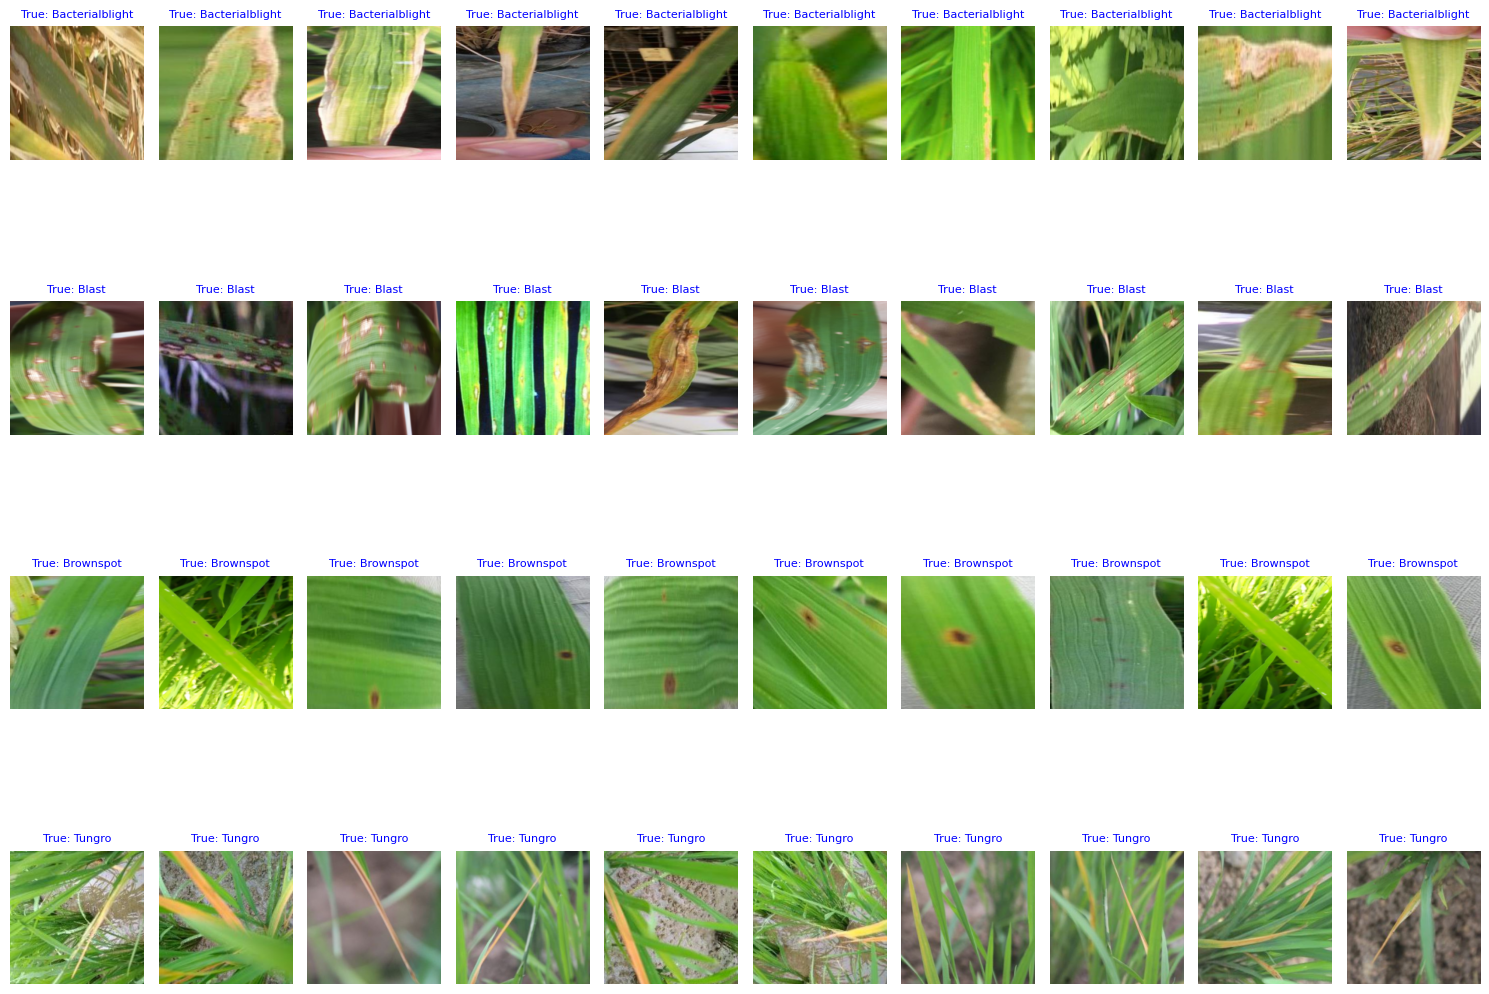

In [16]:
# 测试集数据加载器
data_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # 预处理

test_dataset = CustomImageFolder(root=os.path.join(image_path, "test"), transform=data_transform)
test_num = len(test_dataset.classes)
print(f"Number of classes: {test_num}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# 加载模型参数
ckp = "/content/rice-leaf-desease-resnet152"
pretrained_dict = torch.load(ckp)

# 测试
def predict(data_loader, model, device):
    model.eval()
    class_samples = {i: [] for i in range(test_num)}
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(inputs.size(0)):
                class_idx = labels[i].item()
                class_samples[class_idx].append((inputs[i], labels[i], predicted[i]))

    accuracy = 100 * correct / total
    return class_samples, accuracy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

class_samples, accuracy = predict(test_loader, net, device)

print('accuracy in test dataset: ', accuracy)
print()

# 可视化
def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # 反归一化
    img = np.clip(img, 0, 1)
    return img

# 字体设置
font1 = {'color': 'blue', 'size': 8}
font2 = {'color': 'red', 'size': 8}

# 创建一个大图，包含所有类别的前10个样本
fig, axs = plt.subplots(test_num, 10, figsize=(15, 3 * test_num))

for class_idx in range(test_num):
    samples = class_samples[class_idx]
    if len(samples) > 10:
        selected_samples = random.sample(samples, 10)
    else:
        selected_samples = samples
    for i, (image, label, predicted) in enumerate(selected_samples):
        ax = axs[class_idx, i]
        ax.imshow(imshow(image))
        ax.axis('off')
        if label == predicted:
            title = f'True: {test_dataset.classes[label]}'
            title_font = font1
        else:
            title = f'True: {test_dataset.classes[label]}\nPred: {test_dataset.classes[predicted]}'
            title_font = font2
        ax.set_title(title, fontdict=title_font)

plt.tight_layout()
plt.show()

# 无标签数据测试

Blast 0.99911517


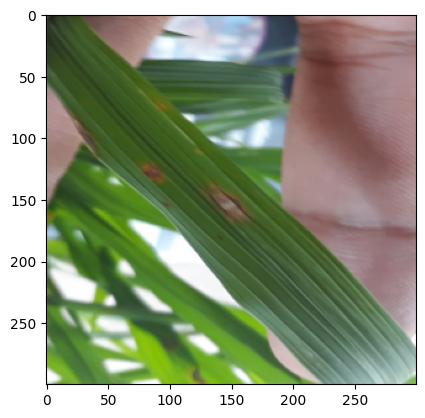

In [11]:
from PIL import Image
import cv2

# load image
img = Image.open("/content/dataset/test/Blast/BLAST1_002.jpg")#导入需要检测的图片
plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
try:
    json_file = open('/content/class_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

# create model
model = resnet152(num_classes=4) # 训练时一共的种类数
# load model weights
model_weight_path = "/content/rice-leaf-desease-resnet152" # 导入训练好的模型
model.load_state_dict(torch.load(model_weight_path, map_location=device))
model.eval()
with torch.no_grad():   # 不对损失梯度进行跟踪
    # predict class
    output = torch.squeeze(model(img))  # 压缩batch维度
    predict = torch.softmax(output, dim=0)  # 得到概率分布
    predict_cla = torch.argmax(predict).numpy()     # argmax寻找最大值对应的索引
print(class_indict[str(predict_cla)], predict[predict_cla].numpy())
plt.show()